### Import Required Libraries

In [3]:
import string
import re
from numpy import array, argmax, random, take
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

In [4]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [5]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [6]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [7]:
deu_eng = deu_eng[:100000,:]

In [8]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["You don't have to tell me.",
        'Das brauchen Sie mir nicht zu sagen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3059155 (Hybrid) & #3059457 (Pfirsichbaeumchen)'],
       ["You don't know everything.", 'Du weißt nicht alles.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2273999 (CK) & #10121413 (Pfirsichbaeumchen)'],
       ["You don't know everything.", 'Ihr wisst nicht alles.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2273999 (CK) & #10121414 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [9]:
# Remove punctuation 
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [10]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['You dont have to tell me',
        'Das brauchen Sie mir nicht zu sagen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3059155 (Hybrid) & #3059457 (Pfirsichbaeumchen)'],
       ['You dont know everything', 'Du weißt nicht alles',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2273999 (CK) & #10121413 (Pfirsichbaeumchen)'],
       ['You dont know everything', 'Ihr wisst nicht alles',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2273999 (CK) & #10121414 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [11]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [12]:
deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['you dont have to tell me',
        'das brauchen sie mir nicht zu sagen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3059155 (Hybrid) & #3059457 (Pfirsichbaeumchen)'],
       ['you dont know everything', 'du weißt nicht alles',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2273999 (CK) & #10121413 (Pfirsichbaeumchen)'],
       ['you dont know everything', 'ihr wisst nicht alles',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2273999 (CK) & #10121414 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [13]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))
print(max(deu_l))
print(max(eng_l))

17
8


In [14]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

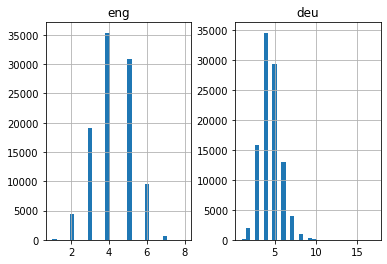

In [15]:
length_df.hist(bins = 30)
plt.show()

In [16]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 8965


In [18]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 15958


In [19]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [20]:
import pickle
with open('eng_tokenizer.pickle', 'wb') as handle:
    pickle.dump(eng_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
with open('deu_tokenizer.pickle', 'wb') as handle:
    pickle.dump(deu_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.05, random_state = 1)

In [24]:
test[:,0].shape

(5000,)

In [25]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [26]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [27]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [28]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [29]:
#@title Default title text
filename = 'arpanKaModel'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
149/149 [==============================] - 425s 3s/step - loss: 3.5016 - val_loss: 3.1396

Epoch 00001: val_loss improved from inf to 3.13963, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 2/30
149/149 [==============================] - 439s 3s/step - loss: 2.9481 - val_loss: 2.8103

Epoch 00002: val_loss improved from 3.13963 to 2.81028, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 3/30
149/149 [==============================] - 423s 3s/step - loss: 2.6454 - val_loss: 2.5568

Epoch 00003: val_loss improved from 2.81028 to 2.55684, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 4/30
149/149 [==============================] - 439s 3s/step - loss: 2.4040 - val_loss: 2.3608

Epoch 00004: val_loss improved from 2.55684 to 2.36081, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 5/30
149/149 [==============================] - 434s 3s/step - loss: 2.1723 - val_loss: 2.1499

Epoch 00005: val_loss improved from 2.36081 to 2.14986, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 6/30
149/149 [==============================] - 386s 3s/step - loss: 1.9567 - val_loss: 1.9968

Epoch 00006: val_loss improved from 2.14986 to 1.99684, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 7/30
149/149 [==============================] - 340s 2s/step - loss: 1.7686 - val_loss: 1.8484

Epoch 00007: val_loss improved from 1.99684 to 1.84840, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 8/30
149/149 [==============================] - 344s 2s/step - loss: 1.5984 - val_loss: 1.7298

Epoch 00008: val_loss improved from 1.84840 to 1.72982, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 9/30
149/149 [==============================] - 340s 2s/step - loss: 1.4505 - val_loss: 1.6228

Epoch 00009: val_loss improved from 1.72982 to 1.62282, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 10/30
149/149 [==============================] - 339s 2s/step - loss: 1.3171 - val_loss: 1.5533

Epoch 00010: val_loss improved from 1.62282 to 1.55335, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 11/30
149/149 [==============================] - 339s 2s/step - loss: 1.1978 - val_loss: 1.4628

Epoch 00011: val_loss improved from 1.55335 to 1.46276, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 12/30
149/149 [==============================] - 340s 2s/step - loss: 1.0917 - val_loss: 1.4063

Epoch 00012: val_loss improved from 1.46276 to 1.40634, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 13/30
149/149 [==============================] - 336s 2s/step - loss: 0.9978 - val_loss: 1.3687

Epoch 00013: val_loss improved from 1.40634 to 1.36867, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 14/30
149/149 [==============================] - 337s 2s/step - loss: 0.9128 - val_loss: 1.3295

Epoch 00014: val_loss improved from 1.36867 to 1.32950, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 15/30
149/149 [==============================] - 337s 2s/step - loss: 0.8357 - val_loss: 1.2967

Epoch 00015: val_loss improved from 1.32950 to 1.29674, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 16/30
149/149 [==============================] - 337s 2s/step - loss: 0.7669 - val_loss: 1.2864

Epoch 00016: val_loss improved from 1.29674 to 1.28642, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 17/30
149/149 [==============================] - 399s 3s/step - loss: 0.7032 - val_loss: 1.2850

Epoch 00017: val_loss improved from 1.28642 to 1.28497, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 18/30
149/149 [==============================] - 401s 3s/step - loss: 0.6453 - val_loss: 1.2502

Epoch 00018: val_loss improved from 1.28497 to 1.25017, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 19/30
149/149 [==============================] - 370s 2s/step - loss: 0.5917 - val_loss: 1.2351

Epoch 00019: val_loss improved from 1.25017 to 1.23513, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 20/30
149/149 [==============================] - 339s 2s/step - loss: 0.5425 - val_loss: 1.2403

Epoch 00020: val_loss did not improve from 1.23513
Epoch 21/30
149/149 [==============================] - 336s 2s/step - loss: 0.4974 - val_loss: 1.2357

Epoch 00021: val_loss did not improve from 1.23513
Epoch 22/30
149/149 [==============================] - 336s 2s/step - loss: 0.4558 - val_loss: 1.2333

Epoch 00022: val_loss improved from 1.23513 to 1.23331, saving model to arpanKaModel


INFO:tensorflow:Assets written to: arpanKaModel\assets


INFO:tensorflow:Assets written to: arpanKaModel\assets


Epoch 23/30
149/149 [==============================] - 338s 2s/step - loss: 0.4175 - val_loss: 1.2346

Epoch 00023: val_loss did not improve from 1.23331
Epoch 24/30
149/149 [==============================] - 338s 2s/step - loss: 0.3831 - val_loss: 1.2474

Epoch 00024: val_loss did not improve from 1.23331
Epoch 25/30
149/149 [==============================] - 336s 2s/step - loss: 0.3522 - val_loss: 1.2419

Epoch 00025: val_loss did not improve from 1.23331
Epoch 26/30
149/149 [==============================] - 337s 2s/step - loss: 0.3238 - val_loss: 1.2496

Epoch 00026: val_loss did not improve from 1.23331
Epoch 27/30
149/149 [==============================] - 336s 2s/step - loss: 0.2981 - val_loss: 1.2693

Epoch 00027: val_loss did not improve from 1.23331
Epoch 28/30
149/149 [==============================] - 336s 2s/step - loss: 0.2747 - val_loss: 1.2671

Epoch 00028: val_loss did not improve from 1.23331
Epoch 29/30
149/149 [==============================] - 337s 2s/step - loss: 

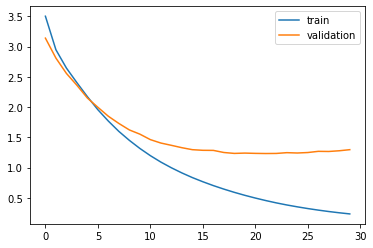

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [29]:
testX.shape

(5000, 8)

In [31]:
model = load_model('arpanKaModel')
preds = np.argmax(model.predict(testX),axis=-1)

In [32]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [33]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [34]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [35]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

In [ ]:
pred_df.tail(15)

In [ ]:
pred_df.tail(15)

In [36]:
pred_df.sample(15)

,actual,predicted
1416,the book is out of print,the book is out of
196,im feeling bad,i feel bad
4153,i like snow,i like snow
3449,i want you to be happy,i want you to be happy
142,who cares,who you doing that
1285,youre extroverted,youre extroverted
4604,may i quote you,may i think you
3634,im horrible,im horrible
992,tom is a hard worker,tom works hard
1741,i cant carry a tune,im very
